In [76]:
from single_globule import Flow

In [121]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

## Spherical globule

Increase the number of points to get better histograms

In [122]:
Flow.Umax = 4.0
Flow.NR = 10_000
flow = Flow()

### Look at the velocity law

(0.0, 4.15)

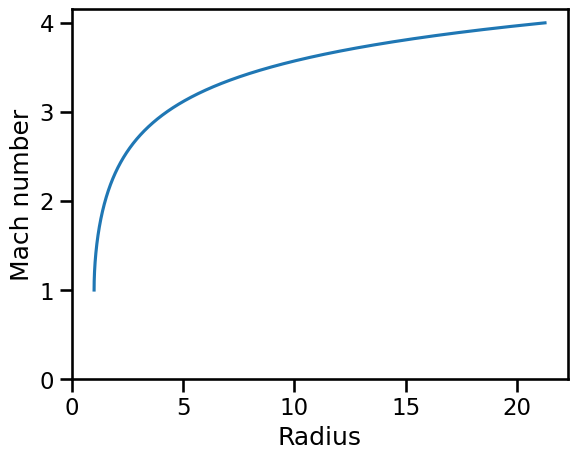

In [123]:
fig, ax = plt.subplots()
ax.plot(flow.R_edges, flow.U_edges)
ax.set_xlabel("Radius")
ax.set_ylabel("Mach number")
ax.set_ylim(0, None)

### Look at the density profile

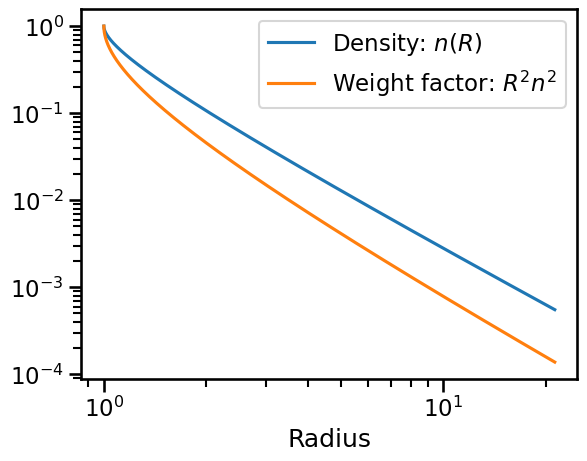

In [124]:
fig, ax = plt.subplots()
ax.plot(flow.R_edges, flow.density_edges, label="Density: $n(R)$")
ax.plot(flow.R_edges, flow.R_edges**2 * flow.density_edges**2, label="Weight factor: $R^2 n^2$")
ax.set_xlabel("Radius")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

## Calculating $H_n$ from the gradient of the velocity law

### General velocity law
In general case (for spherical geometry) we have
$$
H_n \, dn = e \, dV = n^2 R^2 \, d R
$$
so that 
$$
H_n = \frac{n^2 R^2}{|d n / d R|}
$$
where
$$
\frac{d n}{d R} = \frac{d}{d R} U^{-1} R^{-2}
= - 2 U^{-1} R^{-3} - R^{-2} U^{-2} \frac{d U}{d R}
= \frac{- 2}{U R^3} \left( 1 + \frac{R}{U}\frac{d U}{d R}\right)
$$
Given that 
$$
n = \frac{1}{U R^2}
$$
we therefore have that 
$$
H_n = \frac{R^2 U R^3}{2 U^2 R^4 (1 + d \ln U / d \ln R)} = \frac{R}{2 U (1 + d \ln U / d \ln R)}
$$

### Constant velocity wind

In this case $U = 1$, $d\ln U / d\ln R = 0$, we get 
$$
H_n = \frac12 R = \frac12 n^{-1/2}
$$
which is exactly the same as I derived in the handwritten notes

### Dyson velocity law

We can probably calculate the derivative analytically, but first I will do it by finite differences

In [135]:
dlnU_dlnR = np.gradient( np.log(flow.U_edges), np.log(flow.R_edges) )

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_38534/294597078.py:3: RuntimeWarning: divide by zero encountered in power
  ax.plot(flow.R_edges - 1, np.sqrt(0.5) * (flow.R_edges - 1)**-0.5, linestyle="dotted", lw=3, label="$(2 (R - 1))^{-1/2}$")


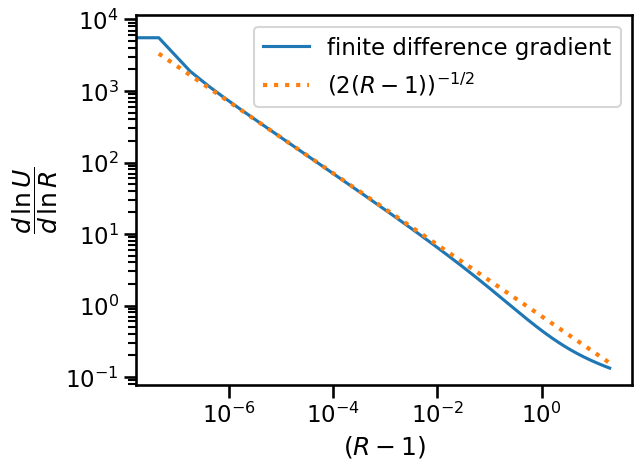

In [158]:
fig, ax = plt.subplots()
ax.plot(flow.R_edges - 1, dlnU_dlnR, label="finite difference gradient")
ax.plot(flow.R_edges - 1, np.sqrt(0.5) * (flow.R_edges - 1)**-0.5, linestyle="dotted", lw=3, label="$(2 (R - 1))^{-1/2}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("$(R - 1)$")
ax.set_ylabel(r"$\dfrac{d \, \ln U}{d \, \ln R}$")
ax.legend()

That looks very close to a power law in $(R - 1)$ (see orange dotted line, although not exactly).

So we now have all we need to calculate $H_n$

In [159]:
Hn = flow.R_edges / 2 / flow.U_edges / (1 + dlnU_dlnR)

But we also need to normalize it so that it integrates to unity. 

In [170]:
Hn0 = np.trapezoid(Hn, flow.density_edges)
abs(Hn0)

np.float64(0.17247109387323176)

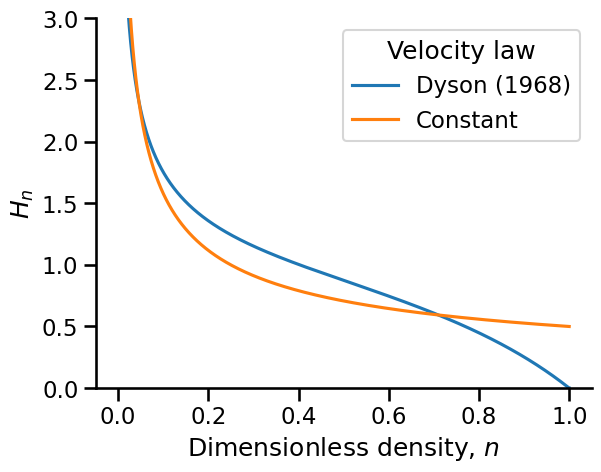

In [173]:
fig, ax = plt.subplots()
ax.plot(flow.density_edges, Hn / abs(Hn0), label="Dyson (1968)")
ax.plot(flow.density_edges, 0.5 / np.sqrt(flow.density_edges), label="Constant")
ax.set_ylim(0, 3.0)
ax.set_xlabel("Dimensionless density, $n$")
ax.set_ylabel("$H_n$")
ax.legend().set_title("Velocity law")
sns.despine()

Finally, we can convert to log space and find the Density Energy Distribution: $n H_n$

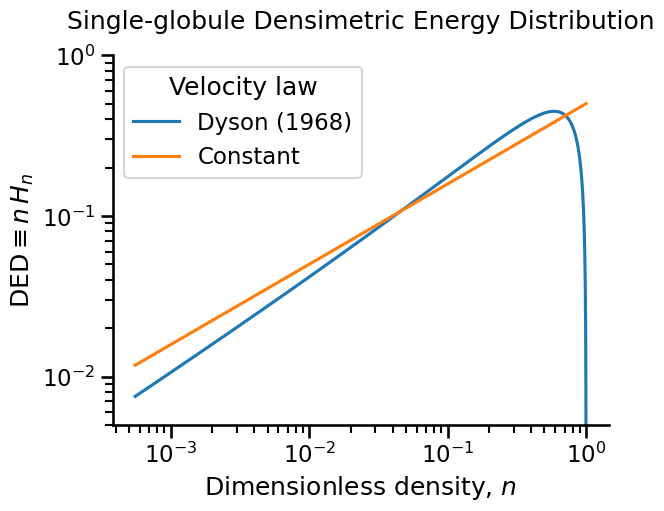

In [179]:
fig, ax = plt.subplots()
ax.plot(flow.density_edges, flow.density_edges * Hn / abs(Hn0), label="Dyson (1968)")
ax.plot(flow.density_edges, 0.5 * np.sqrt(flow.density_edges), label="Constant")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(5e-3, 1.0)
ax.set_xlabel("Dimensionless density, $n$")
ax.set_ylabel(r"DED$\equiv n\, H_n$")
ax.legend().set_title("Velocity law")
ax.set_title(r"Single-globule Densimetric Energy Distribution", y=1.05)

sns.despine()
fig.savefig("single-globule-ded.pdf", bbox_inches="tight")

### Possible change of notation

If we are going to talk about the *Density Energy Distribution* then we should maybe call it 
$$ 
\frac{d E}{d \log_e n}
$$
where
$$
E = \int_{\mathrm{volume}} e\, dV
\quad
\mathrm{and}
\quad
e \equiv 4\pi j = h\nu \, \alpha_{\mathrm{eff}} \, n^2
$$
is luminosity for some recombination line, such as H$\alpha$ (assuming that internal extinction can be neglected). Or it could be free-free radio emission, so long as we are on the flat part of the radio spectrum (optically thin). 

Then we could either use a dimensional form (with units of solar luminosities, for instance) or a non-dimensional form:
$$
\frac{1}{E} \frac{d E}{d \log_e n} = \frac{d \log_e E}{d \log_e n}
$$

### Relation between DED and $s$-PDF and $n$-PDF

For the "standard" log-density PDF I will take the fraction of the *volume* that is occupied by gas of a certain density: 
$$
\frac{d V}{d \log_e n}.
$$
In the turbulence literature, this is called the $s$-pdf, where $s = \log_e \rho / \rho_0$, where $\rho_0$ is the mean density over the volume.  If the density distribution is log-normal then the $s$-pdf is a Gaussian (but see Beattie:2022a for deviations from this). 

Also note that the gaussian is not centered on $s=0$, but instead on $s = s_0 = -\sigma_s^2 / 2$, where $\sigma_s$ is the width of the gaussian in $s$-space.

## Calculate the density histogram

This was my first attempt to calculate the PDF, using the histogram method. It gives the same answer as the analytic calculation above (within the limitations of the discrete sampling). 

In [126]:
H, den_bin_edges = flow.radial_density_histogram(flow.R_edges, flow.density_edges, nbins=100)

First, we do it on a linear scale, calculating $H_n$

Text(0, 0.5, 'Histogram, $H_n$')

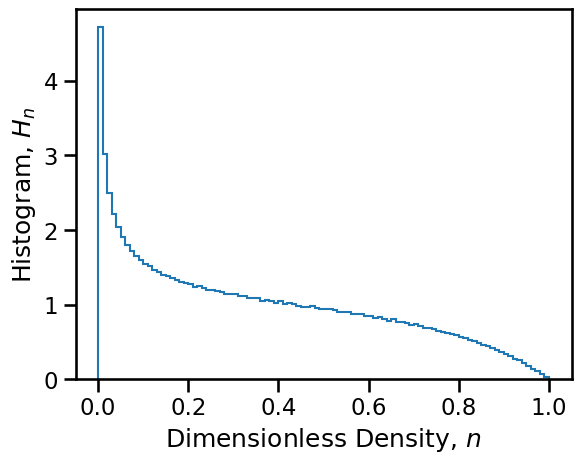

In [127]:
fig, ax = plt.subplots()
ax.stairs(H, den_bin_edges)
ax.set_xlabel("Dimensionless Density, $n$")
ax.set_ylabel("Histogram, $H_n$")

Now calculate the Density Energy Distribution on log scale. The value of the DED is the contribution of each density to the total recombination luminosity of the flow.  It is normalized such that 
$$
\int_{n = 0}^1 \mathrm{DED}(n) \, d \log_e n = 1
$$


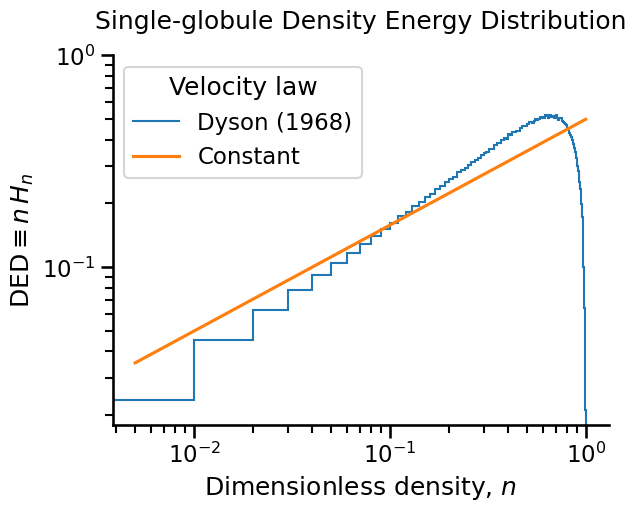

In [130]:
fig, ax = plt.subplots()
den_bin_centers = 0.5*(den_bin_edges[1:] + den_bin_edges[:-1])

ax.stairs(H * den_bin_centers, den_bin_edges, label="Dyson (1968)")
ax.plot(den_bin_centers, 0.5 * den_bin_centers ** 0.5, label="Constant")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(None, 1.0)
ax.legend().set_title("Velocity law")
ax.set_title(r"Single-globule Density Energy Distribution", y=1.05)
ax.set_xlabel("Dimensionless density, $n$")
ax.set_ylabel(r"DED$\equiv n \,H_n$")
sns.despine()

This looks more reasonable now.  The orange line is the constant velocity result

#

## Test the integration of emissivity

In [ ]:
np.trapzd(flow.R_edges

In [17]:
flow.alpha

2.0

In [24]:
radii, densities = flow.R_edges, flow.density_edges

In [27]:
import numpy as np

In [28]:
radii_centers = 0.5 * (radii[:-1] + radii[1:])
volume_elements = radii_centers**flow.alpha * np.diff(radii)
density_centers = 0.5 * (densities[:-1] + densities[1:])
weights = density_centers**2 * volume_elements


In [33]:
radii_centers

array([8.00538937e-06, 2.39741390e-05, 3.98809816e-05, 5.57274152e-05,
       7.15149164e-05, 8.72449411e-05, 1.02918925e-04, 1.18538283e-04,
       1.34104411e-04, 1.49618688e-04, 1.65082471e-04, 1.80497100e-04,
       1.95863900e-04, 2.11184175e-04, 2.26459213e-04, 2.41690288e-04,
       2.56878654e-04, 2.72025553e-04, 2.87132209e-04, 3.02199832e-04,
       3.17229618e-04, 3.32222746e-04, 3.47180385e-04, 3.62103687e-04,
       3.76993791e-04, 3.91851825e-04, 4.06678903e-04, 4.21476126e-04,
       4.36244583e-04, 4.50985353e-04, 4.65699499e-04, 4.80388078e-04,
       4.95052133e-04, 5.09692695e-04, 5.24310788e-04, 5.38907422e-04,
       5.53483600e-04, 5.68040313e-04, 5.82578543e-04, 5.97099263e-04,
       6.11603438e-04, 6.26092020e-04, 6.40565957e-04, 6.55026186e-04,
       6.69473635e-04, 6.83909227e-04, 6.98333875e-04, 7.12748483e-04,
       7.27153950e-04, 7.41551166e-04, 7.55941015e-04, 7.70324373e-04,
       7.84702110e-04, 7.99075090e-04, 8.13444168e-04, 8.27810195e-04,
      